In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import tifffile
import cv2
import os
from patchify import patchify  #Only to handle large images
import random
# from scipy import ndimage

In [2]:
from  pycocotools.coco import COCO

In [3]:
root = "/media/wd/T7/data/for_sam_test/"
filelist = os.listdir(root)
filelist = [os.path.join(root, f) for f in filelist if f.endswith(".json")]

In [4]:
large_images = []
large_masks = []
for file in filelist:
    coco = COCO(file)
    image = cv2.imread(file[:-4]+"png", -1)
    masks = []
    for i in coco.anns.keys():
        mask= coco.annToMask(coco.anns[i])
        large_masks.append(mask)
        large_images.append(image)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 250

In [6]:
all_img_patches = []
for img in range(len(large_images)):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(len(large_masks)):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 1).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [7]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.sum() > 100]
index = random.sample(valid_indices, 600)
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[index]
filtered_masks = masks[index]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (600, 256, 256)
Mask shape: (600, 256, 256)


In [8]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# # Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [9]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 600
})

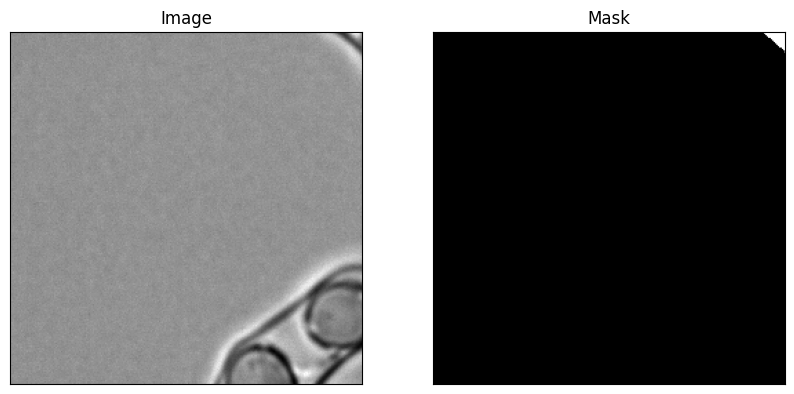

In [10]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [11]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    return bbox

def get_points(ground_truth_map, n=1, patch=1):
    # get bounding box from mask
    points = []
    labels = []
    for j in range(0, patch):
        point = []
        label = []
        y_indices, x_indices = np.where(ground_truth_map > 0)
        index = np.random.randint(0, len(x_indices), n)
        for i in index:
            point.append([x_indices[i], y_indices[i]])
            label.append(1)
        points.append(point)
        labels.append(label)
    return points, labels
    # return bbox

In [12]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt_bbox = get_bounding_box(ground_truth_mask)
    prompt_point = get_points(ground_truth_mask, n=1, patch=16)
    # prepare image and prompt for the model
    #self.processor.set_image(image)
    inputs = self.processor(image,
                            # input_boxes=[[prompt]],
                            input_points = [prompt_point[0]],
                            input_labels = [prompt_point[1]],
                            return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [13]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [14]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [15]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([16, 1, 2])
input_labels torch.Size([16, 1])
ground_truth_mask (256, 256)


In [16]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)

In [17]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_points torch.Size([1, 16, 1, 2])
input_labels torch.Size([1, 16, 1])
ground_truth_mask torch.Size([1, 256, 256])


In [18]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-huge")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [19]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [20]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

print(batch["input_points"].shape)
print(batch["input_labels"].shape)

torch.Size([1, 16, 1, 2])
torch.Size([1, 16, 1])


In [21]:
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_points=batch["input_points"].to(device),
                      input_labels=batch["input_labels"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = 0
      for i in range(0,predicted_masks.shape[1]):
          loss += seg_loss(predicted_masks[:,i,:,:], ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())
      # print(f'Mean loss: {mean(epoch_losses)}')
      
      del outputs
      del predicted_masks
      del ground_truth_masks
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 0
Mean loss: 1.5626301960771283


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 1
Mean loss: 1.3874088727061946


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 2
Mean loss: 1.3075928935036063


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 3
Mean loss: 1.3030761865774791


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 4
Mean loss: 1.2302394107480843


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 5
Mean loss: 1.2314505549271901


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 6
Mean loss: 1.1721378669515252


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 7
Mean loss: 1.178778374940157


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 8
Mean loss: 1.2218181193371613


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 9
Mean loss: 1.1239379957069953


100%|███████████████████████████████████████████████████| 600/600 [10:25<00:00,  1.04s/it]


EPOCH: 10
Mean loss: 1.1170084766795239


100%|███████████████████████████████████████████████████| 600/600 [10:25<00:00,  1.04s/it]


EPOCH: 11
Mean loss: 1.1348666269828875


100%|███████████████████████████████████████████████████| 600/600 [10:25<00:00,  1.04s/it]


EPOCH: 12
Mean loss: 1.0862104413906732


100%|███████████████████████████████████████████████████| 600/600 [10:25<00:00,  1.04s/it]


EPOCH: 13
Mean loss: 1.0704011069610715


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 14
Mean loss: 1.0903118466958404


100%|███████████████████████████████████████████████████| 600/600 [10:25<00:00,  1.04s/it]


EPOCH: 15
Mean loss: 1.083413870582978


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 16
Mean loss: 1.0532592875013749


100%|███████████████████████████████████████████████████| 600/600 [10:26<00:00,  1.04s/it]


EPOCH: 17
Mean loss: 1.09063382918636


100%|███████████████████████████████████████████████████| 600/600 [10:25<00:00,  1.04s/it]


EPOCH: 18
Mean loss: 1.052046761798362


100%|███████████████████████████████████████████████████| 600/600 [10:25<00:00,  1.04s/it]

EPOCH: 19
Mean loss: 1.0672076932030419


In [22]:
torch.save(model.state_dict(), "/media/wd/T7/data/for_sam_test/mito_model_checkpoint_1018.pth")

In [1]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [11]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-huge")
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")


# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/media/wd/T7/data/for_sam_test/mito_model_checkpoint_1018.pth"))

<All keys matched successfully>

In [2]:
aaa = torch.load("/media/wd/T7/data/for_sam_test/mito_model_checkpoint_1018.pth")

In [3]:
bbb = torch.load("../models/sam_vit_h_4b8939.pth")

In [4]:
KEYS_TO_MODIFY_MAPPING = {
    "iou_prediction_head.layers.0": "iou_prediction_head.proj_in",
    "iou_prediction_head.layers.1": "iou_prediction_head.layers.0",
    "iou_prediction_head.layers.2": "iou_prediction_head.proj_out",
    "mask_decoder.output_upscaling.0": "mask_decoder.upscale_conv1",
    "mask_decoder.output_upscaling.1": "mask_decoder.upscale_layer_norm",
    "mask_decoder.output_upscaling.3": "mask_decoder.upscale_conv2",
    "mask_downscaling.0": "mask_embed.conv1",
    "mask_downscaling.1": "mask_embed.layer_norm1",
    "mask_downscaling.3": "mask_embed.conv2",
    "mask_downscaling.4": "mask_embed.layer_norm2",
    "mask_downscaling.6": "mask_embed.conv3",
    "point_embeddings": "point_embed",
    "pe_layer.positional_encoding_gaussian_matrix": "shared_embedding.positional_embedding",
    "image_encoder": "vision_encoder",
    "neck.0": "neck.conv1",
    "neck.1": "neck.layer_norm1",
    "neck.2": "neck.conv2",
    "neck.3": "neck.layer_norm2",
    "patch_embed.proj": "patch_embed.projection",
    ".norm": ".layer_norm",
    "blocks": "layers",
}

In [5]:
import re
import copy

state_dict = bbb
model_state_dict = aaa
to_old_name_dict = {}
state_dict.pop("pixel_mean", None)
state_dict.pop("pixel_std", None)

output_hypernetworks_mlps_pattern = r".*.output_hypernetworks_mlps.(\d+).layers.(\d+).*"

for key, value in state_dict.items():
    m_key = copy.copy(key)
    for key_to_modify, new_key in KEYS_TO_MODIFY_MAPPING.items():
        if key_to_modify in key:
            m_key= m_key.replace(key_to_modify, new_key)
    if re.match(output_hypernetworks_mlps_pattern, m_key):
        layer_nb = int(re.match(output_hypernetworks_mlps_pattern, m_key).group(2))
        if layer_nb == 0:
            m_key = m_key.replace("layers.0", "proj_in")
        elif layer_nb == 1:
            m_key = m_key.replace("layers.1", "layers.0")
        elif layer_nb == 2:
            m_key = m_key.replace("layers.2", "proj_out")

    to_old_name_dict[key] = model_state_dict[m_key]

In [6]:
to_old_name_dict.keys() == bbb.keys()

True

In [7]:
torch.save(to_old_name_dict, "/media/wd/T7/data/for_sam_test/mito_model_checkpoint_1018_oldname.pth")

In [12]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-31): 32 x SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

In [13]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Mask')

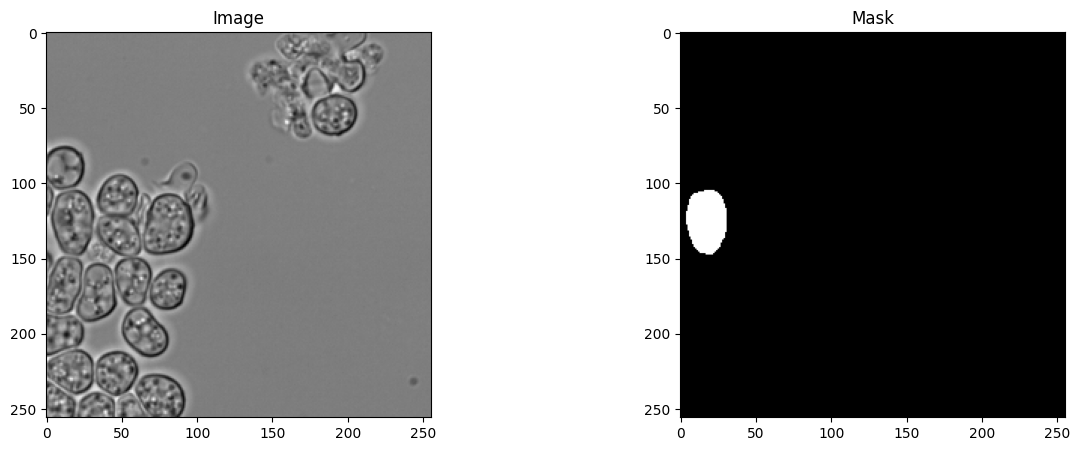

In [17]:
idx = 54
test_image = dataset[idx]["image"]
test_mask = dataset[idx]["label"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(test_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

In [20]:
# let's take a random training example
idx = 10#random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacty of 7.78 GiB of which 466.31 MiB is free. Process 104695 has 3.08 GiB memory in use. Including non-PyTorch memory, this process has 3.64 GiB memory in use. Of the allocated memory 2.59 GiB is allocated by PyTorch, and 62.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF